In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from fontTools.ttLib import TTFont
from PIL import Image, ImageDraw, ImageFont

In [2]:
def get_existing_chars(filename):
    ttfont = TTFont(filename)
    return list({chr(key) for table in ttfont['cmap'].tables for key in table.cmap.keys()})

In [3]:
def get_image(font, char, size=96):
    img = Image.new('L', (1000,1000), 255)
    
    draw = ImageDraw.Draw(img)
    draw.text((200,200), char, font=font)
    
    npimg = 255 - np.array(img)
    wmin = npimg.sum(0).nonzero()[0].min()
    wmax = npimg.sum(0).nonzero()[0].max()
    hmin = npimg.sum(1).nonzero()[0].min()
    hmax = npimg.sum(1).nonzero()[0].max()
    
    npimg = 255 - npimg[hmin:hmax+1,wmin:wmax+1]
    
    whdiff = (wmax-wmin) - (hmax-hmin)
    wmargin = abs(whdiff) // 2 if whdiff < 0 else 0
    hmargin = abs(whdiff) // 2 if whdiff >= 0 else 0

    npimg = np.pad(npimg, ((hmargin, hmargin), (wmargin, wmargin)),
                       'constant', constant_values=255)
    img = Image.fromarray(npimg).resize((size, size), resample=Image.BILINEAR)
    return img
    

In [4]:
# utf-8
def get_all_korean():
    
    def nextKorLetterFrom(letter):
        lastLetterInt = 15572643
        if not letter:
            return '가'
        a = letter
        b = a.encode('utf8')
        c = int(b.hex(), 16)

        if c == lastLetterInt:
            return False

        d = hex(c + 1)
        e = bytearray.fromhex(d[2:])

        flag = True
        while flag:
            try:
                r = e.decode('utf-8')
                flag = False
            except UnicodeDecodeError:
                c = c+1
                d = hex(c)
                e = bytearray.fromhex(d[2:])
        return e.decode()
    
    returns = []
    flag = True
    k = ''
    while flag:
        k = nextKorLetterFrom(k)
        if k is False:
            flag = False
        else:
            returns.append(k)
    return returns
    

In [5]:
'''
- 그냥 자음 모음도 다 모아야 할 필요성 있음.
- 학습에서 제외하기: 애국가 2절 4절
    학습: 안녕하세요 ㅎㅎ 네넵녭 ㄱㄱㄱ ㅋㅋㅋ
    제외: 감사합니다ㅠㅠ 예옙 알겠습니다
- 영어 대소문자도 모으기
'''

'\n- 그냥 자음 모음도 다 모아야 할 필요성 있음.\n- 학습에서 제외하기: 애국가 2절 4절\n    학습: 안녕하세요 ㅎㅎ 네넵녭 ㄱㄱㄱ ㅋㅋㅋ\n    제외: 감사합니다ㅠㅠ 예옙 알겠습니다\n- 영어 대소문자도 모으기\n'

In [6]:
ak = get_all_korean()

In [7]:
eng = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
kl = "ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㄲㄸㅃㅆㅉㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣㅐㅒㅔㅖㅘㅙㅚㅝㅞㅟㅢ"
sm = "0123456789!@#$%^&*()-_=+,.[]<>{}?/~♡♥"

In [8]:
all_letters = ak + [*eng] + [*kl] + [*sm]

In [9]:
fd = "data/raw/ttfs/"
ttfs = [(fd+f, f.split(".ttf")[0]) for f in os.listdir(fd) if ".ttf" in f]

In [10]:
png_fd = "data/raw/pngs/"

In [11]:
test_ttf = [t for t in ttfs if t[1]=="UhBee BongSik BOLD"]

In [12]:
test_ttf

[('data/raw/ttfs/UhBee BongSik BOLD.ttf', 'UhBee BongSik BOLD')]

In [ ]:
chardf = pd.DataFrame(ak)
chardf.to_parquet("data/raw/all_korean.parquet")
pbar = tqdm(range(len(ttfs)))
# pbar = tqdm(range(1))
c = 0
for i in pbar:
    ttf = ttfs[i]
    # ttf = test_ttf[0]
    filename = ttf[0]
    try:
        font = ImageFont.truetype(filename,255)
        existing_chars = get_existing_chars(filename)
        savepics = True
    except:
        savepics = False
    if savepics:
        for j in range(len(chardf)):
        # for j in range(10):
            if not os.path.exists(png_fd+'%s__%s.png'%(ttf[1],str(j))):
                char = chardf.iloc[j].values[0]
                if char in existing_chars:
                    try:
                        img = get_image(font, char)
                        with open(png_fd+'%s__%s.png'%(ttf[1],str(j)), "wb") as f:
                            img.save(f, "PNG")
                    except:
                        # print(ttf[1], ttf[2], char)
                        c += 1
                else:
                    c += 1
    pbar.set_postfix(passed=str(c), files=str(len(os.listdir(png_fd))))

  8%|▊         | 30/377 [05:10<1:12:16, 12.50s/it, files=56663, passed=267325]

In [129]:
# for f in tqdm(os.listdir(png_fd)):
#     if ".png" in f:
#         os.remove(png_fd+f)

100%|██████████| 11399/11399 [00:00<00:00, 84798.86it/s]


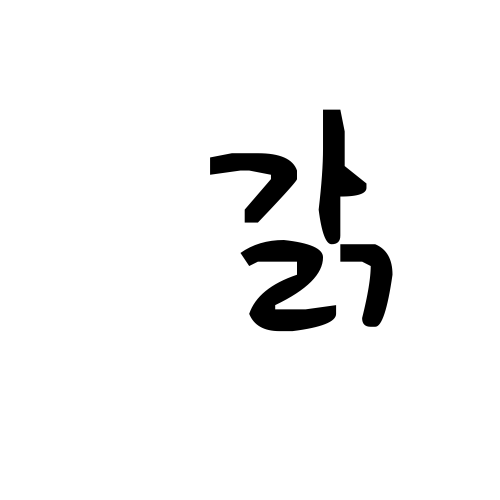

In [ ]:
all_pngs = [f for f in os.listdir(png_fd) if ".png" in f]
for t in ttfs:
    n_letters = len([f for f in all_pngs if t[1] in f])
    if n_letters > 10000:
        print(t[1], n_letters)
    elif n_letters > 5000:
        print(t[1], n_letters)